# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 1. Deep Learning for Vision

**Upside down detector**: Train a model to detect if images are upside down

* ~~Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))~~

* ~~Synthetically turn some of images upside down. Create a training and test set.~~
* ~~Build a neural network (using Tensorflow, PyTorch, or any framework you like)~~
* ~~Train it to classify image orientation until a reasonable accuracy is reached~~
* ~~[Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.~~
* ~~Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)~~

**Submission instructions**: Please write your code below and include some examples of images that were classified

In [ ]:
!pip install datasets
!pip install torchmetrics

In [119]:
# Common imports
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision import models, transforms
from enum import Enum
import torch.nn as nn
from tqdm import tqdm
import torchmetrics
from torch.optim.lr_scheduler import OneCycleLR
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [14]:
# config
config = {
    "batch_size": 64,
    "num_epochs": 5,
    "lr": 0.005,
    "betas": (0.9, 0.999),
    "eps": 1e-6,
    "lr": 8e-3,
    "do_eval": True
}

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

def set_seed(seed):
    """Sets a seed in all available libraries."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

In [4]:
# obtaining the dataset
from datasets import load_dataset

data = load_dataset("nateraw/auto-cats-and-dogs")

Using custom data configuration default


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/nateraw___image_folder/default/0.0.0/fe6d5c42acbfe3cb5099f4445ae47edb9d337aee440fee08096b64d4f2a008df. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
def create_splits(data):
    train_testvalid = data.train_test_split(0.2)
    test_valid = train_testvalid['test'].train_test_split(0.5)
    train_split = train_testvalid['train']
    val_split = test_valid['train']
    test_split = test_valid['test']
    return train_split, val_split, test_split

class UpsideDownDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self): 
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx]['file']).convert("RGB")
        label = np.random.randint(2)
        if label == 1:
            img = img.rotate(180)
        x = self.transform(img)
        return {'X': x, 'y': torch.tensor(label, dtype=torch.int)}

In [51]:
class UpsideDownClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_ft = models.resnet18(pretrained=True)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, 1)
    
    def forward(self, x):
        return self.model_ft(x).squeeze()

    def predict(self,x):
        pred = torch.functional.softmax(self.forward(x))
        return torch.tensor(pred)

In [88]:
class Trainer():
    def __init__(self,
                 training_args,
                 device,
                 model: UpsideDownClassifier,
                 dataloaders):
        self.training_args = training_args
        self.device = device
        self.model = model
        self.dataloaders = dataloaders
        self.metrics = torchmetrics.Accuracy().to(device)
    
    def train(self):
        self.optimizer = torch.optim.AdamW(self.model.parameters(),
                                           lr=self.training_args['lr'],
                                           betas=self.training_args['betas'],
                                           eps=self.training_args['eps'])
        self.lr_scheduler = OneCycleLR(
            optimizer=self.optimizer,
            max_lr=self.training_args["lr"],
            epochs=self.training_args["num_epochs"],
            steps_per_epoch=len(self.dataloaders['train']))
        
        history = defaultdict(list)
        for epoch in range(self.training_args["num_epochs"]):
            self.model.train()
            running_loss = 0.0
            running_acc = 0.0
            samples = 0
            for t, (batch) in enumerate(tqdm(self.dataloaders['train'],
                                        desc=f"Epoch {epoch} batch"), 1):
                x = batch['X'].to(self.device)
                y = batch['y'].to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(x)
                loss = nn.functional.binary_cross_entropy_with_logits(outputs, y.float())
                loss.backward()
                self.optimizer.step()
                self.lr_scheduler.step()

                running_loss += loss
                samples += x.shape[0]
                running_acc += self.metrics(outputs, y)
            history['train_loss'].append((running_loss/samples).item())
            history['train_acc'].append(self.metrics.compute().item())
            self.metrics.reset()
            if self.training_args['do_eval']:
                history = self.evaluate(mode='val', history=history)
        return history

    def evaluate(self, mode, history=None):
        if history is None:
            history = defaultdict(list)
        print("Starting Evaluation")
        self.model.eval()
        running_loss = 0.0
        samples = 0
        for batch in tqdm(self.dataloaders[mode],
                          desc="Evaluating batch"):
            x = batch['X'].to(device)
            y = batch['y'].to(device)
            with torch.no_grad():
                outputs = self.model(x)
            self.metrics(outputs, y)
            samples += x.shape[0]
            running_loss += nn.functional.binary_cross_entropy_with_logits(outputs, y.float())
        history[f'{mode}_loss'].append((running_loss/samples).item())
        history[f'{mode}_acc'].append(self.metrics.compute().item())
        self.metrics.reset()
        return history

In [89]:
set_seed(42)

data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_split, val_split, test_split = create_splits(data['train'])
train_gen = UpsideDownDataset(train_split, data_transforms)
val_gen = UpsideDownDataset(val_split, data_transforms)
test_gen = UpsideDownDataset(test_split, data_transforms)

dataloaders = {
    'train' : torch.utils.data.DataLoader(train_gen, 
                                          batch_size=config['batch_size'],
                                          shuffle=True,
                                          drop_last=True),
    'val' : torch.utils.data.DataLoader(val_gen, 
                                        batch_size=config['batch_size']),
    'test' : torch.utils.data.DataLoader(test_gen,
                                         batch_size=config['batch_size'])}

model = UpsideDownClassifier().to(device)

trainer = Trainer(
    training_args=config,
    device=device,
    model=model,
    dataloaders=dataloaders)

history = trainer.train()

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/nateraw___image_folder/default/0.0.0/fe6d5c42acbfe3cb5099f4445ae47edb9d337aee440fee08096b64d4f2a008df/cache-1dc25e0d9bc264a2.arrow and /root/.cache/huggingface/datasets/nateraw___image_folder/default/0.0.0/fe6d5c42acbfe3cb5099f4445ae47edb9d337aee440fee08096b64d4f2a008df/cache-a49951f16a233c83.arrow
Loading cached split indices for dataset at /root/.cache/huggingface/datasets/nateraw___image_folder/default/0.0.0/fe6d5c42acbfe3cb5099f4445ae47edb9d337aee440fee08096b64d4f2a008df/cache-65e1e3576625f052.arrow and /root/.cache/huggingface/datasets/nateraw___image_folder/default/0.0.0/fe6d5c42acbfe3cb5099f4445ae47edb9d337aee440fee08096b64d4f2a008df/cache-4c095905c49b41b4.arrow
Epoch 0 batch: 100%|██████████| 292/292 [05:07<00:00,  1.05s/it]


Starting Evaluation


Epoch 1 batch: 100%|██████████| 292/292 [05:06<00:00,  1.05s/it]


Starting Evaluation


Epoch 2 batch: 100%|██████████| 292/292 [05:10<00:00,  1.06s/it]


Starting Evaluation


Epoch 3 batch: 100%|██████████| 292/292 [05:08<00:00,  1.06s/it]


Starting Evaluation


Epoch 4 batch: 100%|██████████| 292/292 [05:06<00:00,  1.05s/it]


Starting Evaluation


Evaluating batch: 100%|██████████| 37/37 [00:20<00:00,  1.83it/s]


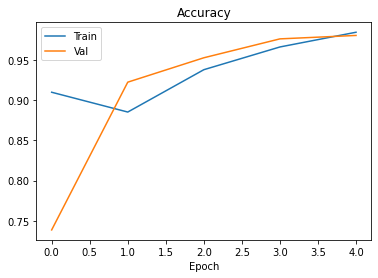

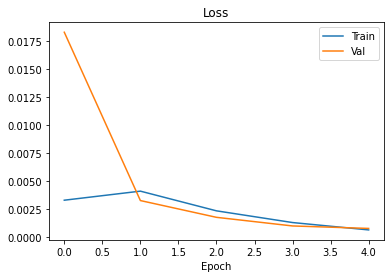

In [91]:
plt.figure()
plt.title('Accuracy')
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.legend(['Train', 'Val'])
plt.xlabel('Epoch')
plt.show()

plt.figure()
plt.title('Loss')
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.legend(['Train', 'Val'])
plt.xlabel('Epoch')
plt.show()

In [94]:
# saving the model
torch.save(trainer.model.state_dict(), '/content/upsidedownclassifier.pt')

In [105]:
# Results in test set
history = trainer.evaluate(mode='test')
print(f"\nAccuracy in Test Set: {history['test_acc']}")

Starting Evaluation


Evaluating batch: 100%|██████████| 37/37 [00:20<00:00,  1.80it/s]


Accuracy in Test Set: [0.9696710705757141]


Batch Acc: 0.9375
Labels: [1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1]
Pred: [1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1]


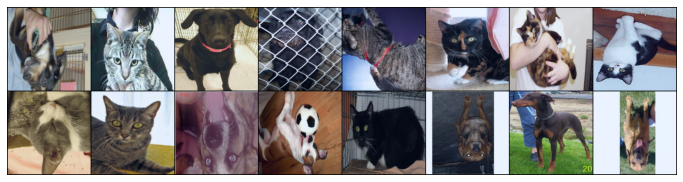

In [129]:
# Visualizing some errors
loader = torch.utils.data.DataLoader(test_gen, batch_size=16, shuffle=True)

for t, (batch) in enumerate(loader):
    x = batch['X'].to(device)
    y = batch['y'].to(device)
    outputs = trainer.model(x)
    acc = trainer.metrics(outputs, y)

    if acc < 1:
        print(f'Batch Acc: {acc}')
        pred = np.asarray(outputs.cpu() > 0, dtype=int)
        print(f"Labels: {np.asarray(batch['y'], dtype=int)}")
        print(f"Pred: {pred}")
        plt.figure(figsize=(12,8))
        plt.imshow(np.transpose(vutils.make_grid(batch['X'],
                                                 padding=2,
                                                 normalize=True).cpu(),(1,2,0)))
        plt.axis('off')
        plt.show()
        break

**Write up**: 
* Link to the model on Hugging Face Hub: https://huggingface.co/israfelsr/UpsideDownClassifier
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

Some options to obtain better results will be:
- **Use a more complex model**. Here we are using resnet18 but there are models with more parameters or we can jump into a fancier implementation for instance a vision transformer.
- **Use data augmentation**. We can crop some images to augmentate the dataset wee are training.

Some comments:
- We can see that the model that was picked performs really good on the task. This si because it's pretrained on IMAGENET (a big dataset) and also it's a big model (with a lot of parameters).
- We can also see that the selected number of training epochs was correct. The evaluation acc started to be stucked.

# 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

# 3. Deep RL / Robotics

**RL for Classical Control:** Using any of the [classical control](https://github.com/openai/gym/blob/master/docs/environments.md#classic-control) environments from OpenAI's `gym`, implement a deep NN that learns an optimal policy which maximizes the reward of the environment.

* Describe the NN you implemented and the behavior you observe from the agent as the model converges (or diverges).
* Plot the reward as a function of steps (or Epochs).
Compare your results to a random agent.
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.
* (Optional) [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.


You may use any frameworks you like, but you must implement your NN on your own (no pre-defined/trained models like [`stable_baselines`](https://stable-baselines.readthedocs.io/en/master/)).

You may use any simulator other than `gym` _however_:
* The environment has to be similar to the classical control environments (or more complex like [`robosuite`](https://github.com/ARISE-Initiative/robosuite)).
* You cannot choose a game/Atari/text based environment. The purpose of this challenge is to demonstrate an understanding of basic kinematic/dynamic systems.

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* (Optional) link to the model on Hugging Face Hub: 
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.

# 4. Theory / Linear Algebra 

**Implement Contrastive PCA** Read [this paper](https://www.nature.com/articles/s41467-018-04608-8) and implement contrastive PCA in Python.

* First, please discuss what kind of dataset this would make sense to use this method on
* Implement the method in Python (do not use previous implementations of the method if they already exist)
* Then create a synthetic dataset and apply the method to the synthetic data. Compare with standard PCA.


**Write up**: Discuss what kind of dataset it would make sense to use Contrastive PCA

In [ ]:
### WRITE YOUR CODE HERE

# 5. Systems

**Inference on the edge**: Measure the inference times in various computationally-constrained settings

* Pick a few different speech detection models (we suggest looking at models  on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads))
* Simulate different memory constraints and CPU allocations that are realistic for edge devices that might run such models, such as smart speakers or microcontrollers, and measure what is the average inference time of the models under these conditions 
* How does the inference time vary with (1) choice of model (2) available system memory (3) available CPU (4) size of input?

Are there any surprising discoveries? (Note that this coding challenge is fairly open-ended, so we will be considering the amount of effort invested in discovering something interesting here).

In [ ]:
### WRITE YOUR CODE HERE

**Write up**: What surprising discoveries do you see?